# `bw_timex` Teaching Example - Time-explicit LCA of an Electric Vehicle

Here's a rundown of the steps involved in a `TimexLCA`:

<div style="display: flex; justify-content: center; background-color: white; border-radius: 15px; padding: 10px; width: 600px; margin: auto;">
  <img src="data/workflow.svg" style="border-radius: 15px; width: 100%;">
</div>

## **Step 0**: Initial Setup *(normal brightway stuff)*

In [1]:
import bw2data as bd

bd.projects.set_current("bw25_ei310_premise")

/Users/timodiepers/anaconda3/envs/timex/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


In [2]:
if "foreground" in bd.databases:
    del bd.databases["foreground"] # to make sure we create the foreground from scratch
foreground = bd.Database("foreground")
foreground.register()

```{mermaid}
flowchart LR
    car_prod_wo_battery(market for passenger car, electric, without battery, GLO):::ei-->ev_production
    battery_production(market for battery, Li-ion, LiMn2O4, rechargeable, prismatic, GLO):::ei-->ev_production
    ev_production(ev production):::fg-->driving
    electricity_generation(market group for electricity, low voltage, GLO):::ei-->driving
    driving(driving ev):::fg-->battery_eol(market for used Li-ion battery, GLO):::ei
    driving-->fu(FU: driving 100,000 km)

    classDef ei color:#222832, fill:#3fb1c5, stroke:none;
    classDef fg color:#222832, fill:#9c5ffd, stroke:none;
```

Legend:
```{mermaid}
flowchart TB
    background(background process):::ei
    foreground(foreground process):::fg

    classDef ei color:#222832, fill:#3fb1c5, stroke:none;
    classDef fg color:#222832, fill:#9c5ffd, stroke:none;
```

### Creating foreground processes

In [3]:
ev_production = foreground.new_node("ev_production", name="production of an electric vehicle", unit="unit")
ev_production['reference product'] = "electric vehicle"
ev_production.save()

driving = foreground.new_node("driving", name="driving an electric vehicle", unit="pkm over ev lifetime")
driving['reference product'] = "person transport"
driving.save()

### Adding exchanges

In [4]:
ELECTRICITY_CONSUMPTION = 0.2 # kWh/km
MILEAGE = 100_000 # km
MASS_CAR_WITHOUT_BATTERY = 840 # kg
MASS_BATTERY = 280 # kg

In [5]:
car_without_battery = bd.get_node(database="ei310_SSP2_RCP19_2025", name="market for passenger car, electric, without battery")
battery = bd.get_node(database="ei310_SSP2_RCP19_2025", name="market for battery, Li-ion, LiMn2O4, rechargeable, prismatic")
electricity = bd.get_node(database="ei310_SSP2_RCP19_2025", name="market group for electricity, low voltage", location="GLO")
battery_eol = bd.get_node(database="ei310_SSP2_RCP19_2025", name="market for used Li-ion battery")

In [6]:
ev_production.new_edge(input=ev_production, amount=1, type="production").save()

car_without_battery_to_ev = ev_production.new_edge(
    input=car_without_battery,
    amount=MASS_CAR_WITHOUT_BATTERY,
    type="technosphere"
)
car_without_battery_to_ev.save()

battery_to_ev = ev_production.new_edge(
    input=battery, 
    amount=MASS_BATTERY, 
    type="technosphere"
)
battery_to_ev.save()

In [7]:
driving.new_edge(input=driving, amount=1, type="production").save()

ev_to_driving = driving.new_edge(
    input=ev_production, 
    amount=1, 
    type="technosphere"
)
ev_to_driving.save()

electricity_to_driving = driving.new_edge(
    input=electricity,
    amount=ELECTRICITY_CONSUMPTION * MILEAGE,
    type="technosphere",
)
electricity_to_driving.save()

driving_to_battery_eol = driving.new_edge(
    input=battery_eol, 
    amount=-MASS_BATTERY, # used battery is "produced"
    type="technosphere"
)
driving_to_battery_eol.save()

With this setup, we could now run a normal, static LCA:

In [8]:
import bw2calc as bc

method = ('EF v3.1', 'climate change', 'global warming potential (GWP100)')
lca = bc.LCA({driving: 1}, method)
lca.lci()
lca.lcia()
lca.score

/Users/timodiepers/anaconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.95e+13)
  warnings.warn(msg, UmfpackWarning)


16951.611057821734

Lateron, we'll want to use prospective background databases. We create those using premise. We save the info which database represent what point in time in a dictionary:

In [9]:
from datetime import datetime

database_dates = {
    "ei310_SSP2_RCP19_2025": datetime.strptime("2020", "%Y"),
    "ei310_SSP2_RCP19_2030": datetime.strptime("2030", "%Y"),
    "ei310_SSP2_RCP19_2040": datetime.strptime("2040", "%Y"),
    "foreground": "dynamic", # Doesn't have a fixed date, but will be distributed over time
}

## **Step 1**: Adding temporal information

```{mermaid}
flowchart LR
    car_prod_wo_battery(market for passenger car, electric, without battery, GLO):::ei-->|1-2 years prior|ev_production
    battery_production(market for battery, Li-ion, LiMn2O4, rechargeable, prismatic, GLO):::ei-->|6-9 months prior|ev_production
    ev_production(ev production):::fg-->|1-3 months prior|driving
    electricity_generation(market group for electricity, low voltage, GLO):::ei-->|uniformly distributed over lifetime|driving
    driving(driving ev):::fg-->|3 months after lifetime|battery_eol(market for used Li-ion battery, GLO):::ei
    driving-->fu(**FU**: driving 100,000 km, *uniformly over lifetime, starting 2025*)

    classDef ei color:#222832, fill:#3fb1c5, stroke:none;
    classDef fg color:#222832, fill:#9c5ffd, stroke:none;
```

### The `TemporalDistribution` class

In [10]:
from bw_temporalis import TemporalDistribution
import numpy as np

td_car_without_battery_production = TemporalDistribution(
    date=np.array([-2, -1], dtype="timedelta64[Y]"), amount=np.array([0.2, 0.8])
)

td_assembly_and_delivery = TemporalDistribution(
    date=np.array([-3, -2, -1], dtype="timedelta64[M]"), amount=np.array([0.3, 0.5, 0.2])
)

#### What do these TDs look like?

<Axes: xlabel='Time (Years)', ylabel='Amount'>

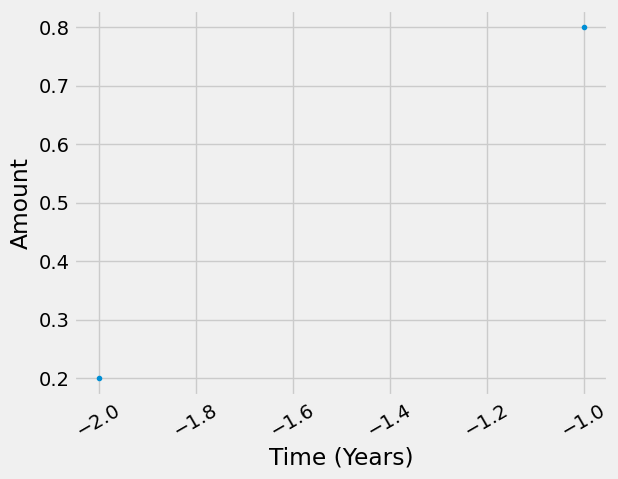

In [11]:
td_car_without_battery_production.graph(resolution="Y")

<Axes: xlabel='Time (Months)', ylabel='Amount'>

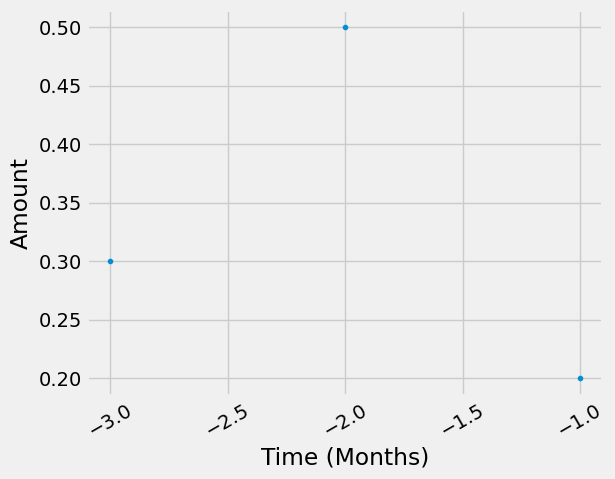

In [12]:
td_assembly_and_delivery.graph(resolution="M")

<Axes: xlabel='Time (Months)', ylabel='Amount'>

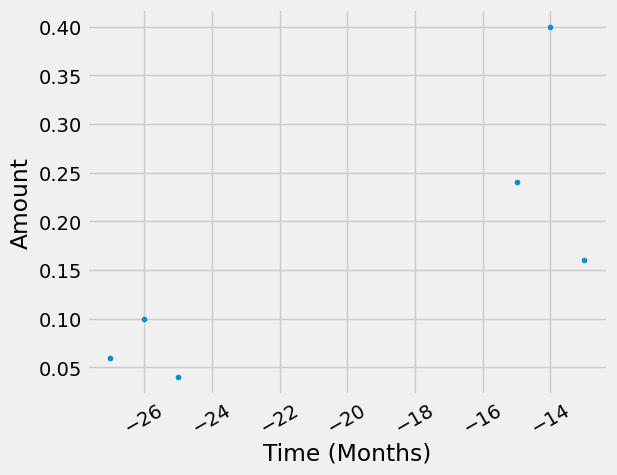

In [13]:
(td_car_without_battery_production * td_assembly_and_delivery).graph(resolution="M")

#### Creating the remaining TDs

In [14]:
from bw_temporalis import easy_timedelta_distribution


td_battery_production = easy_timedelta_distribution(
    start=-9,
    end=-6,
    resolution="M",
    steps=4,
    kind="normal", # you can also use "uniform" or "triangular"
    param=0.5,
)

LIFETIME = 15 # years
td_electricity_consumption = easy_timedelta_distribution(
    start=0,
    end=LIFETIME,
    resolution="Y",
    steps=(LIFETIME + 1),
    kind="uniform",
)

td_battery_eol = TemporalDistribution(
    date=np.array([LIFETIME * 12 + 3], dtype="timedelta64[M]"), amount=np.array([1])
)


#### Adding TDs to the exchanges

In [15]:
car_without_battery_to_ev['temporal_distribution'] = td_car_without_battery_production
car_without_battery_to_ev.save()

battery_to_ev['temporal_distribution'] = td_battery_production
battery_to_ev.save()

ev_to_driving['temporal_distribution'] = td_assembly_and_delivery
ev_to_driving.save()

# if you dont have the exchange object at hand, you can also use our util function:
from bw_timex.utils import add_temporal_distribution_to_exchange

add_temporal_distribution_to_exchange(
    td_electricity_consumption,
    input_node = electricity,
    output_node = driving,
)

add_temporal_distribution_to_exchange(
    td_battery_eol,
    input_node = battery_eol,
    output_node = driving,
)

2025-09-29 15:04:50.174 | INFO     | bw_timex.utils:add_temporal_distribution_to_exchange:455 - Added temporal distribution to exchange Exchange: 20000.0 kilowatt hour 'market group for electricity, low voltage' (kilowatt hour, GLO, None) to 'driving an electric vehicle' (pkm over ev lifetime, GLO, None)>.
2025-09-29 15:04:50.179 | INFO     | bw_timex.utils:add_temporal_distribution_to_exchange:455 - Added temporal distribution to exchange Exchange: -280 kilogram 'market for used Li-ion battery' (kilogram, GLO, None) to 'driving an electric vehicle' (pkm over ev lifetime, GLO, None)>.


## **Step 2**: Building the process timeline

In [16]:
from bw_timex import TimexLCA

In [17]:
tlca = TimexLCA({driving: 1}, method, database_dates)

/Users/timodiepers/anaconda3/envs/timex/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.33e+13)
  warnings.warn(msg, UmfpackWarning)


In [18]:
tlca.build_timeline(starting_datetime="2025-01-01", temporal_grouping="month")

2025-09-29 15:04:56.334 | INFO     | bw_timex.timex_lca:build_timeline:217 - No edge filter function provided. Skipping all edges in background databases.


Starting graph traversal


2025-09-29 15:05:06.341 | INFO     | bw_timex.timeline_builder:get_weights_for_interpolation_between_nearest_years:526 - Reference date 2040-04-01 00:00:00 is higher than all provided dates. Data will be taken from the closest lower year.


Calculation count: 5


,date_producer,producer_name,date_consumer,consumer_name,amount,temporal_market_shares
0,2022-10-01,"market for passenger car, electric, without ba...",2024-10-01,production of an electric vehicle,168.0,"{'ei310_SSP2_RCP19_2025': 0.725, 'ei310_SSP2_R..."
1,2022-11-01,"market for passenger car, electric, without ba...",2024-11-01,production of an electric vehicle,168.0,"{'ei310_SSP2_RCP19_2025': 0.717, 'ei310_SSP2_R..."
2,2022-12-01,"market for passenger car, electric, without ba...",2024-12-01,production of an electric vehicle,168.0,"{'ei310_SSP2_RCP19_2025': 0.708, 'ei310_SSP2_R..."
3,2023-10-01,"market for passenger car, electric, without ba...",2024-10-01,production of an electric vehicle,672.0,"{'ei310_SSP2_RCP19_2025': 0.625, 'ei310_SSP2_R..."
4,2023-11-01,"market for passenger car, electric, without ba...",2024-11-01,production of an electric vehicle,672.0,"{'ei310_SSP2_RCP19_2025': 0.617, 'ei310_SSP2_R..."
5,2023-12-01,"market for passenger car, electric, without ba...",2024-12-01,production of an electric vehicle,672.0,"{'ei310_SSP2_RCP19_2025': 0.609, 'ei310_SSP2_R..."
6,2024-01-01,"market for battery, Li-ion, LiMn2O4, rechargea...",2024-10-01,production of an electric vehicle,54.695544,"{'ei310_SSP2_RCP19_2025': 0.6, 'ei310_SSP2_RCP..."
7,2024-02-01,"market for battery, Li-ion, LiMn2O4, rechargea...",2024-10-01,production of an electric vehicle,85.304456,"{'ei310_SSP2_RCP19_2025': 0.592, 'ei310_SSP2_R..."
8,2024-02-01,"market for battery, Li-ion, LiMn2O4, rechargea...",2024-11-01,production of an electric vehicle,54.695544,"{'ei310_SSP2_RCP19_2025': 0.592, 'ei310_SSP2_R..."
9,2024-03-01,"market for battery, Li-ion, LiMn2O4, rechargea...",2024-10-01,production of an electric vehicle,85.304456,"{'ei310_SSP2_RCP19_2025': 0.584, 'ei310_SSP2_R..."


## **Step 3**: Calculating the time-explicit LCI

In [19]:
tlca.lci()

/Users/timodiepers/anaconda3/envs/timex/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)


Under the hood, before solving the inventory problem, we're re-build the technosphere and biosphere matrices here. New rows and columns are added to carry the extra temporal information. Details are explained in the [Theory Section](https://docs.brightway.dev/projects/bw-timex/en/latest/content/theory.html#modifying-the-matrices) of our docs.

## **Step 4**: Impact assessment

The simplest case, static LCIA:

In [20]:
tlca.static_lcia()
tlca.static_score

9227.485134896491

But there is more: `bw_timex` retains temporal information in the inventory, allowing for dynamic LCIA:

In [21]:
tlca.dynamic_lcia(metric="GWP")

2025-09-29 15:05:26.108 | INFO     | dynamic_characterization.dynamic_characterization:characterize:82 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.


,date,amount,flow,activity
0,2023-01-01,-0.003609,3269,210127807139278852
1,2023-01-01,-0.002166,3269,210127807139278851
2,2023-01-01,-0.001444,3269,210127807139278853
3,2023-01-01,-0.000304,3211,210127807139278852
4,2023-01-01,-0.000183,3211,210127807139278851
...,...,...,...,...
2402,2040-01-01,6.832929,1031,210127807139278882
2403,2040-01-01,7.954375,1034,210127807139278882
2404,2040-01-01,15.745005,1034,210127807139278883
2405,2040-01-01,20.821270,107,210127807139278883


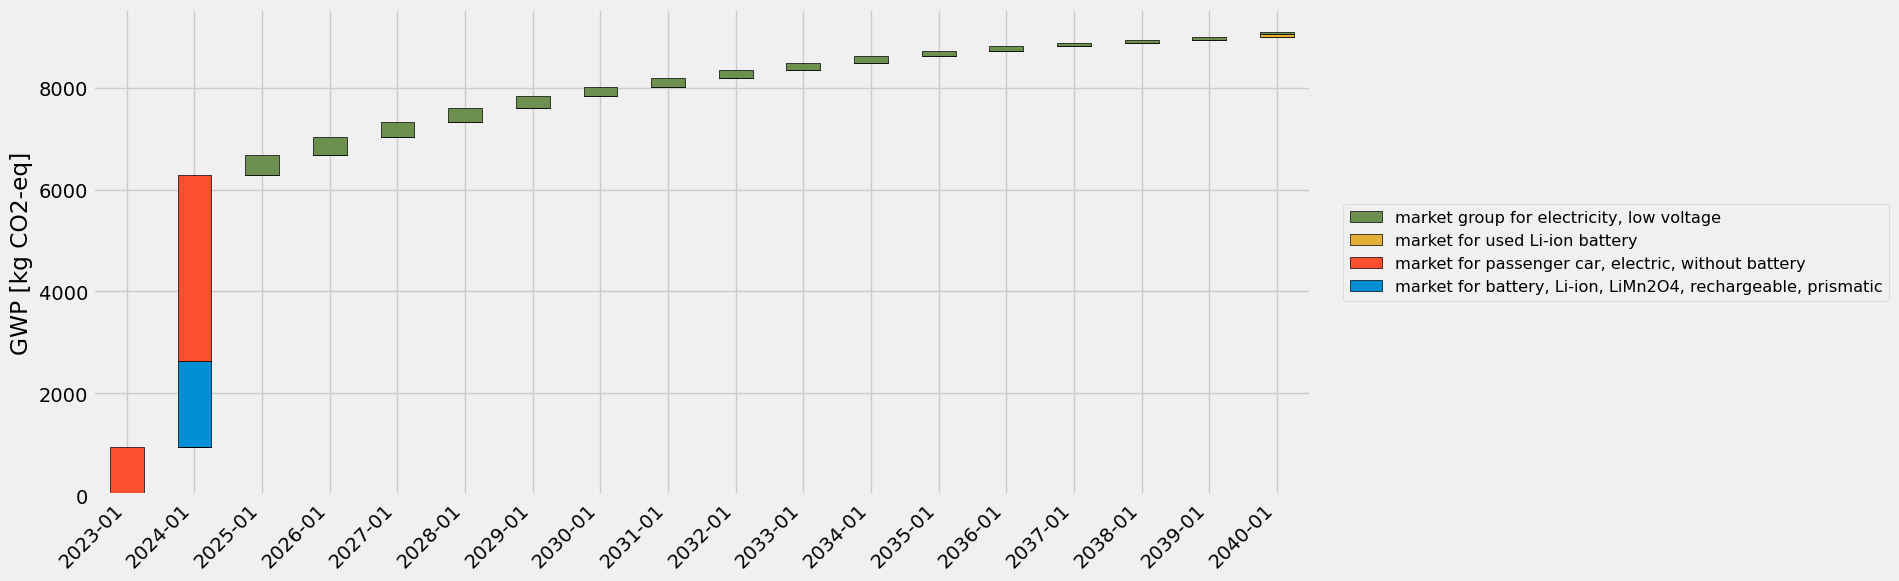

In [22]:
from bw_timex.utils import plot_characterized_inventory_as_waterfall
plot_characterized_inventory_as_waterfall(tlca)

In addition to the "standard" GWP, we can go even more dynamic, directly assessing radiative forcing:

In [23]:
tlca.dynamic_lcia(
    metric="radiative_forcing",
    time_horizon=30,
)

2025-09-29 15:06:31.097 | INFO     | dynamic_characterization.dynamic_characterization:characterize:82 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.


,date,amount,flow,activity
0,2024-01-01 05:49:12,-5.945482e-18,3269,210127807139278852
1,2024-01-01 05:49:12,-3.567472e-18,3269,210127807139278851
2,2024-01-01 05:49:12,-2.378056e-18,3269,210127807139278853
3,2024-01-01 05:49:12,-5.011100e-19,3211,210127807139278852
4,2024-01-01 05:49:12,-3.006822e-19,3211,210127807139278851
...,...,...,...,...
54281,2068-12-31 00:46:48,6.471593e-15,1031,210127807139278882
54282,2068-12-31 00:46:48,7.533735e-15,1034,210127807139278882
54283,2068-12-31 00:46:48,1.491238e-14,1034,210127807139278883
54284,2068-12-31 00:46:48,1.972021e-14,107,210127807139278883


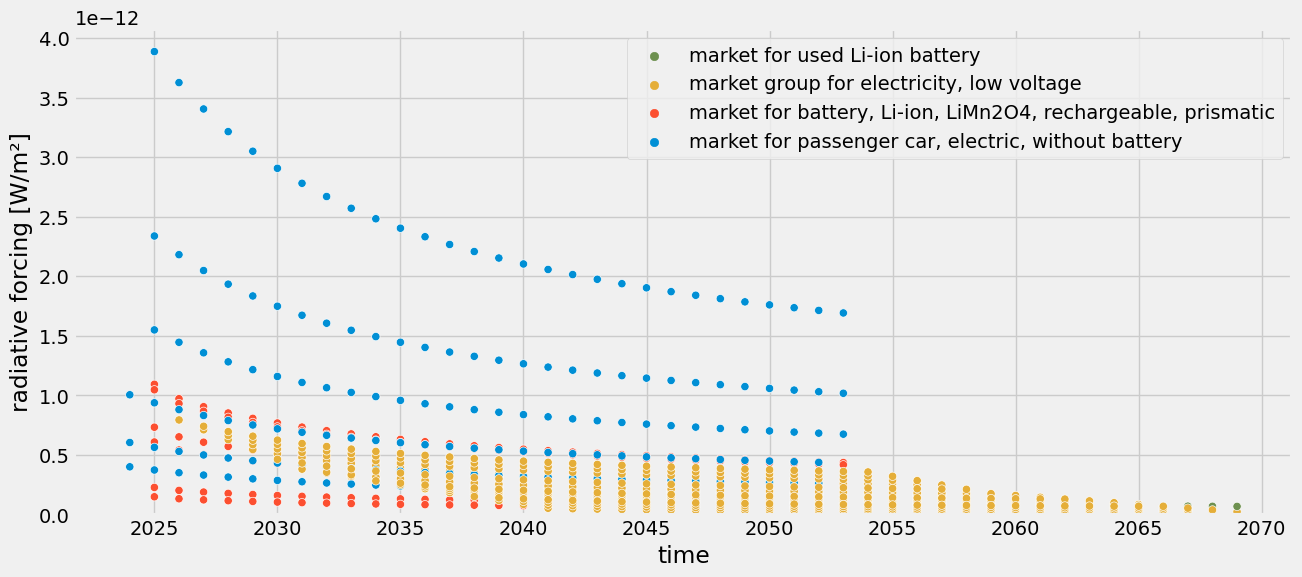

In [24]:
tlca.plot_dynamic_characterized_inventory(
    sum_emissions_within_activity=True,
)